This notebook contains the full pipeline which was implemented for Genomics and Bioinformatics project at EPFL.

In [81]:
import loompy
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Setting scanpy settings
sc.settings.verbosity = 3    
sc.settings.set_figure_params(facecolor='white', figsize=(15, 7))
sc.settings.figdir = './images/'  # Setting the image folder

%matplotlib inline

In [2]:
# Reading the data from loom file
adata = sc.read_loom('./data/Absolute_Final_dataset.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# Some variables (genes) have the same name
adata.var_names_make_unique()

#### Let us take a quick look at the dataset.

In [4]:
adata

AnnData object with n_obs × n_vars = 120804 × 27998
    obs: 'CellType', 'Size_Factor', 'Total_mRNAs', 'age', 'barcode', 'largeVis1', 'largeVis2', 'largeVis3', 'new_CellType', 'num_genes_expressed', 'raw_cluster', 'sample', 'umap2_CellType', 'umap_CellType', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime'
    var: 'bcv', 'gene_short_name', 'id', 'mean_expr', 'num_cells_expressed', 'percent_detection', 'sd_exprs', 'use_for_ordering'

We can see that our dataset contains 120804 observations (cells) and 27998 variables (genes). Each observation and variable has additional annotation. Let us take a look at that too.

In [5]:
adata.obs.head()

CellType  Size_Factor  Total_mRNAs  age                 barcode  \
0             RPCs     1.733369       2794.0  E11  E11.AAACCTGAGATGTAAC-1   
1  Red Blood Cells     7.196523      11600.0  E11  E11.AAACCTGAGCCCAGCT-1   
2             RPCs     2.201143       3548.0  E11  E11.AAACCTGAGGCAATTA-1   
3             RPCs     2.381057       3838.0  E11  E11.AAACCTGAGTAGCGGT-1   
4             RPCs     2.861238       4612.0  E11  E11.AAACCTGAGTGGAGTC-1   

   largeVis1  largeVis2  largeVis3  \
0   2.233818  -2.888105  19.609872   
1  38.667628   1.075194 -14.972134   
2  -0.680810  -1.946963  20.612288   
3   1.603176  -3.168796  21.139159   
4  -0.735997  -2.757505  20.045230   

                                        new_CellType  num_genes_expressed  \
0                                         Early RPCs                 1549   
1                                    Red Blood Cells                 1889   
2                                         Early RPCs                 1848   
3  RPE/Margin/Periocular Mesenchyme/Lens Epitheli...                 1935   
4                                         Early RPCs                 2139   

   raw_cluster sample   umap2_CellType    umap_CellType  umap_cluster  \
0           32    E11       Early RPCs       Early RPCs           130   
1           49    E11  Red Blood Cells  Red Blood Cells           144   
2            9    E11       Early RPCs       Early RPCs           103   
3           24    E11       Early RPCs       Early RPCs           130   
4            9    E11       Early RPCs       Early RPCs           115   

   umap_coord1  umap_coord2  umap_coord3  used_for_pseudotime  
0     3.581455    -4.245770    -3.752502                    0  
1    10.760842     1.156191     0.558124                    0  
2     2.634151    -5.016846    -3.926956                    0  
3     3.268848    -3.967177    -3.942664                    0  
4     3.737625    -4.926516    -4.012058                    1

In [6]:
adata.var.head()

bcv gene_short_name                  id  mean_expr  \
Xkr4       481.954551            Xkr4  ENSMUSG00000051951   0.002119   
Gm1992   30200.249994          Gm1992  ENSMUSG00000089699   0.000033   
Gm37381   2081.844819         Gm37381  ENSMUSG00000102343   0.000480   
Rp1         14.053329             Rp1  ENSMUSG00000025900   0.169481   
Rp1-1             NaN             Rp1  ENSMUSG00000109048   0.000000   

         num_cells_expressed  percent_detection  sd_exprs  use_for_ordering  
Xkr4                     253           0.209430  0.046522                 0  
Gm1992                     4           0.003311  0.005754                 0  
Gm37381                   58           0.048012  0.021906                 0  
Rp1                    11816           9.781133  0.635347                 1  
Rp1-1                      0           0.000000  0.000000                 0

So each cell is already characterized by its cell type, size factor, barcode, developmental age and other features. The genes, in turn, are characterized by BCV - biological coefficient of variation, the mean expression, percentage of cells where it is detected, etc.

## Preprossessing + Quality control

Let us first plot the highly-expressed genes over the whole dataset.

normalizing counts per cell
    finished (0:00:01)


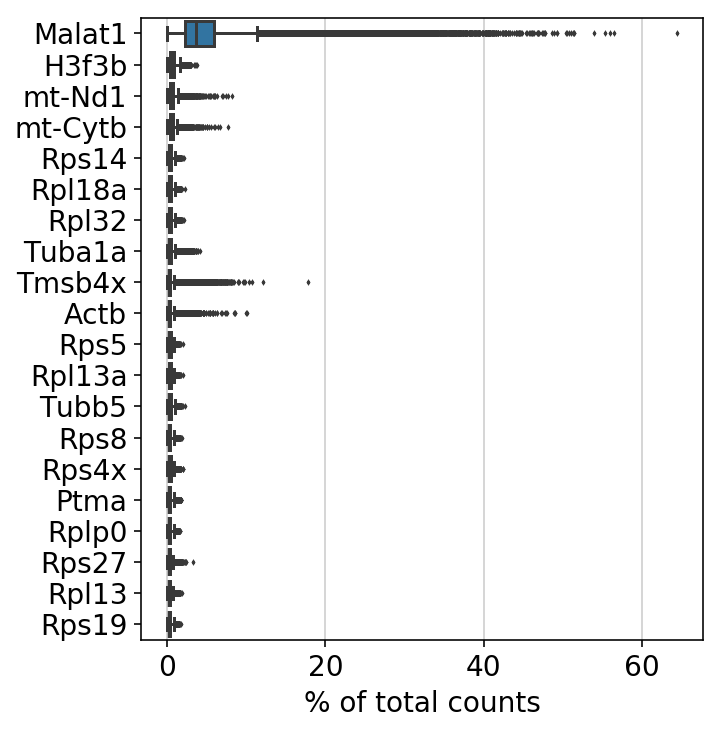

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

From this graph we observe some mitochondrial genes which may indicate high percentage of dying cells, lots of ribosomal genes and [Malat1](https://kb.10xgenomics.com/hc/en-us/articles/360004729092-Why-do-I-see-high-levels-of-Malat1-in-my-gene-expression-data-) expression. Now we may filter the cells and genes by high-pass filtering.

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(f'Now the dataset have {adata.shape[0]} cells and {adata.shape[1]} genes.')

filtered out 4472 cells that have less than 200 genes expressed
filtered out 8298 genes that are detected in less than 3 cells
Now the dataset have 116332 cells and 19700 genes.


Not let us do the quality control of the dataset. To do that we will focus on the percentage of expressed mitochondrial genes in each cell, while also looking at the total counts in each cell and total number of expressed genes in each cell.

In [9]:
# The mitochonrial genes start with 'mt-' prefix
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

... storing 'CellType' as categorical
... storing 'age' as categorical
... storing 'new_CellType' as categorical
... storing 'sample' as categorical
... storing 'umap2_CellType' as categorical
... storing 'umap_CellType' as categorical
... storing 'gene_short_name' as categorical


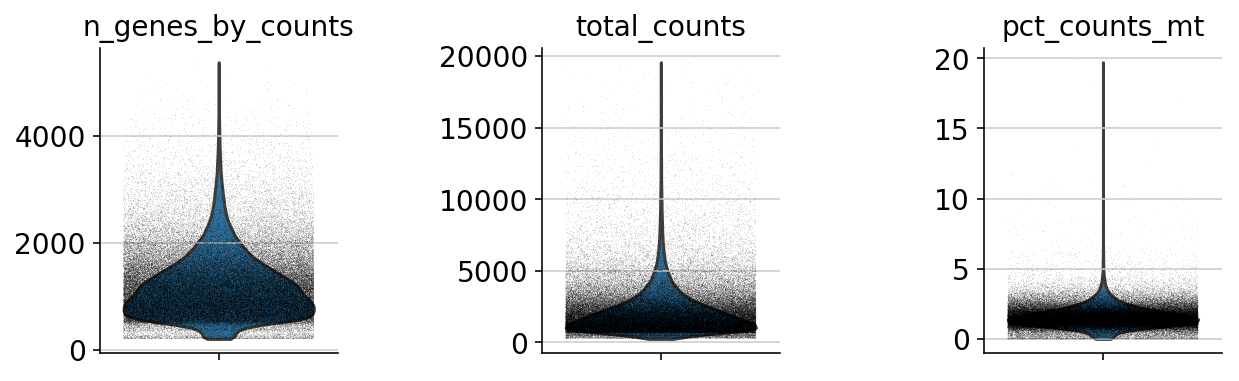

In [10]:
# The violing plot that presents the distributions of different parameters
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size=0.2)

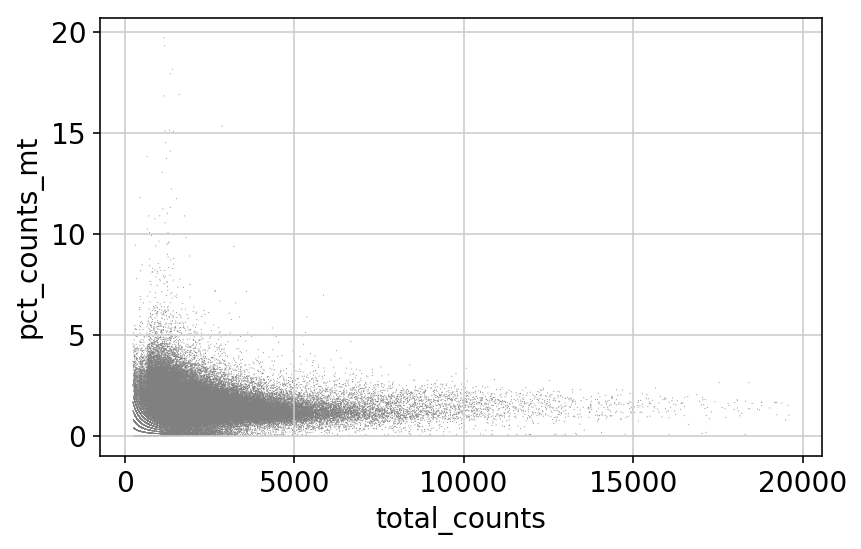

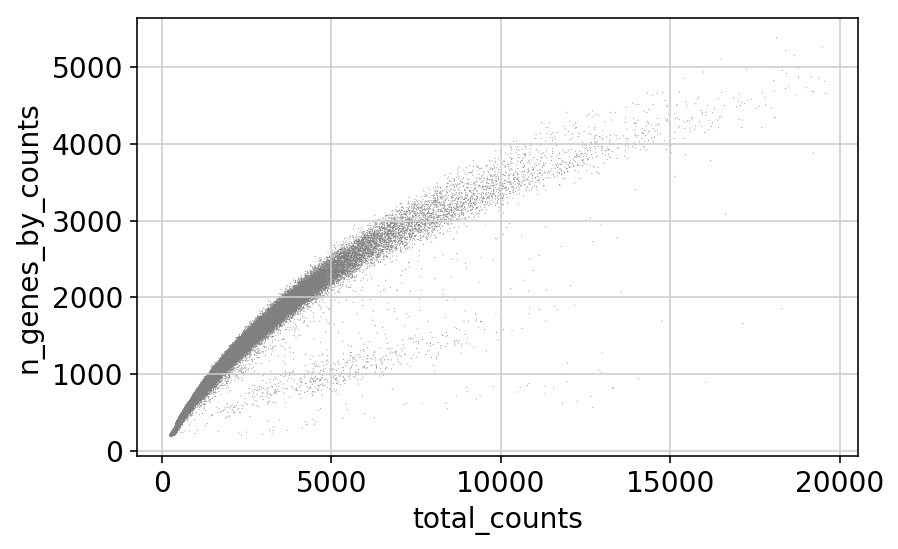

In [11]:
# Plot total counts vs percentage of total mitochondrial genes counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

# Plot total counts vs number of expressed genes
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Looking at the plots above we can set a threshold for filtering out the low quality cells (cells with suspicious level of gene expression and high percentage of mitochondrial genes).

In [12]:
# Setting custom thresholds
n_genes_threshold = 4000
pct_mt_threshold = 5

adata = adata[adata.obs.n_genes_by_counts < n_genes_threshold, :]
adata = adata[adata.obs.pct_counts_mt < pct_mt_threshold, :]

Now we should normalize counts between cells. We will use popular CPM normalization which refers to 'counts per million'.

In [13]:
# Counts scaled by total number of reads per cell and multiplied by scaling factor = 1e6
sc.pp.normalize_total(adata, target_sum=1e6)

/home/maximkryukov/soft/scanpy/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:01)


Let us logarithmize the data (also standard procedure).

In [14]:
# Applying log(x+1)
sc.pp.log1p(adata)

Now let us select highly variable genes which we will focus our analysis on. To do that we will use [Seurat](https://rdrr.io/cran/Seurat/man/FindVariableFeatures.html) package logic - we fit the mean-variance relationship using polynomial regression, standardize the features by fitted mean and variance and calculate the variance by clipping to a maximum. We will extract only top 3290 ones as it was done in original paper.

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


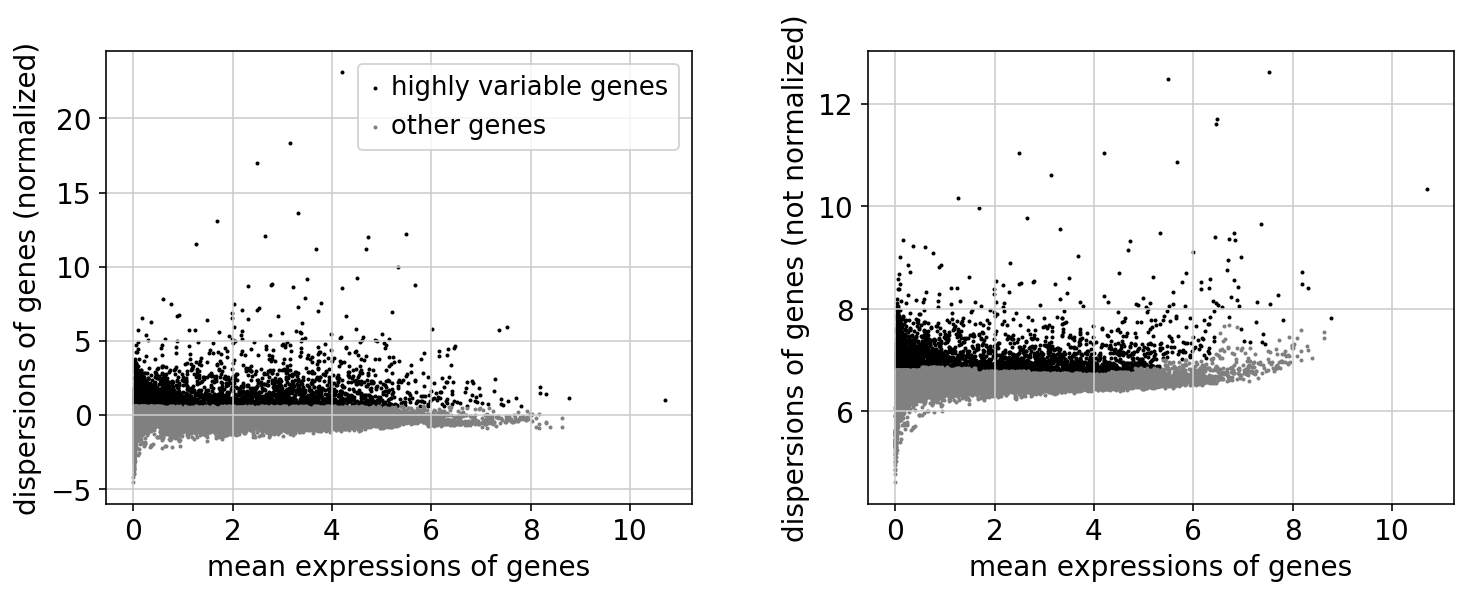

In [15]:
# Getting and plotting highly-variable genes
n_top_genes = 3290

sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
sc.pl.highly_variable_genes(adata)

Now we can finally do the last filtering.

In [16]:
# We save the raw data by setting a new .raw attribute
adata.raw = adata

# Do the filtering of the dataset - extracting top 2000 variable genes
adata = adata[:, adata.var.highly_variable]

# Regressing out the unwanted sources of variation by linear regression
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Standardizing the data (mean = 0, var = 1) and clipping gene variance to 10 if higher
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:05:19)


## Data analysis 1

### Cell profiling along different developmental ages

We may benefit from the annotation of all obtained cells by quantifying the frequency of cell types in each age group. Firstly, we will take a subset of the initial dataset to exclude droplets and non-neural cells.

In [17]:
# Define cell types of interest
cell_types_of_interest = ['Muller Glia', 'Bipolar Cells', 'Rods', 'Cones', 'Photoreceptor Precursors', 
              'Early RPCs', 'Horizontal Cells', 'Amacrine Cells', 'Retinal Ganglion Cells', 
              'Late RPCs', 'Early RPCs', 'Neurogenic Cells']

# Subset initial dataset
adata = adata[adata.obs['new_CellType'].isin(cell_types_of_interest)]

In [18]:
# Getting cell types frequencies for each developmental age
types_per_age = (adata.obs 
                     # Grouping annotation dataframe by age and cell type
                     .groupby(['age', 'new_CellType'])
                     # Count number of cells in each group
                     .count()
                     # Pivot the table such Age is index, and CellType are columns
                     .unstack('new_CellType')['barcode']
                     # Fill NaN values with zeros
                     .fillna(0)
                )

types_per_age

new_CellType  Amacrine Cells  Bipolar Cells   Cones  Early RPCs  Late RPCs  \
age                                                                          
E11                      0.0            0.0     0.0      6678.0        0.0   
E12                      4.0            0.0     0.0      1258.0        0.0   
E14                   1255.0            0.0    21.0     14068.0      255.0   
E16                    346.0            0.0    11.0      1761.0       79.0   
E18                   3999.0            0.0  1550.0       363.0    11256.0   
P0                    1427.0            0.0   666.0        94.0     5188.0   
P2                    1721.0            0.0  1835.0        26.0     8424.0   
P5                     667.0           70.0  1485.0        15.0     1456.0   
P8                      72.0         2153.0   219.0         0.0       59.0   
P14                     40.0          886.0     1.0         3.0        3.0   

new_CellType  Muller Glia  Neurogenic Cells  Photoreceptor Precursors  \
age                                                                     
E11                   0.0               3.0                       0.0   
E12                   0.0              29.0                       1.0   
E14                   0.0            5618.0                     394.0   
E16                   0.0            1999.0                     180.0   
E18                   0.0            2535.0                    1609.0   
P0                    0.0            1127.0                     793.0   
P2                   13.0            1395.0                    3125.0   
P5                  322.0             231.0                    1052.0   
P8                  404.0               9.0                     270.0   
P14                 727.0               0.0                       0.0   

new_CellType  Retinal Ganglion Cells    Rods  
age                                           
E11                              0.0     0.0  
E12                              6.0     0.0  
E14                           4881.0     0.0  
E16                            915.0     0.0  
E18                            445.0     9.0  
P0                              43.0     7.0  
P2                              10.0   115.0  
P5                              14.0   909.0  
P8                               0.0  8299.0  
P14                              1.0  1875.0

Let us now plot the stacked barplot and visualize the frequency of certain cell type in each age group.

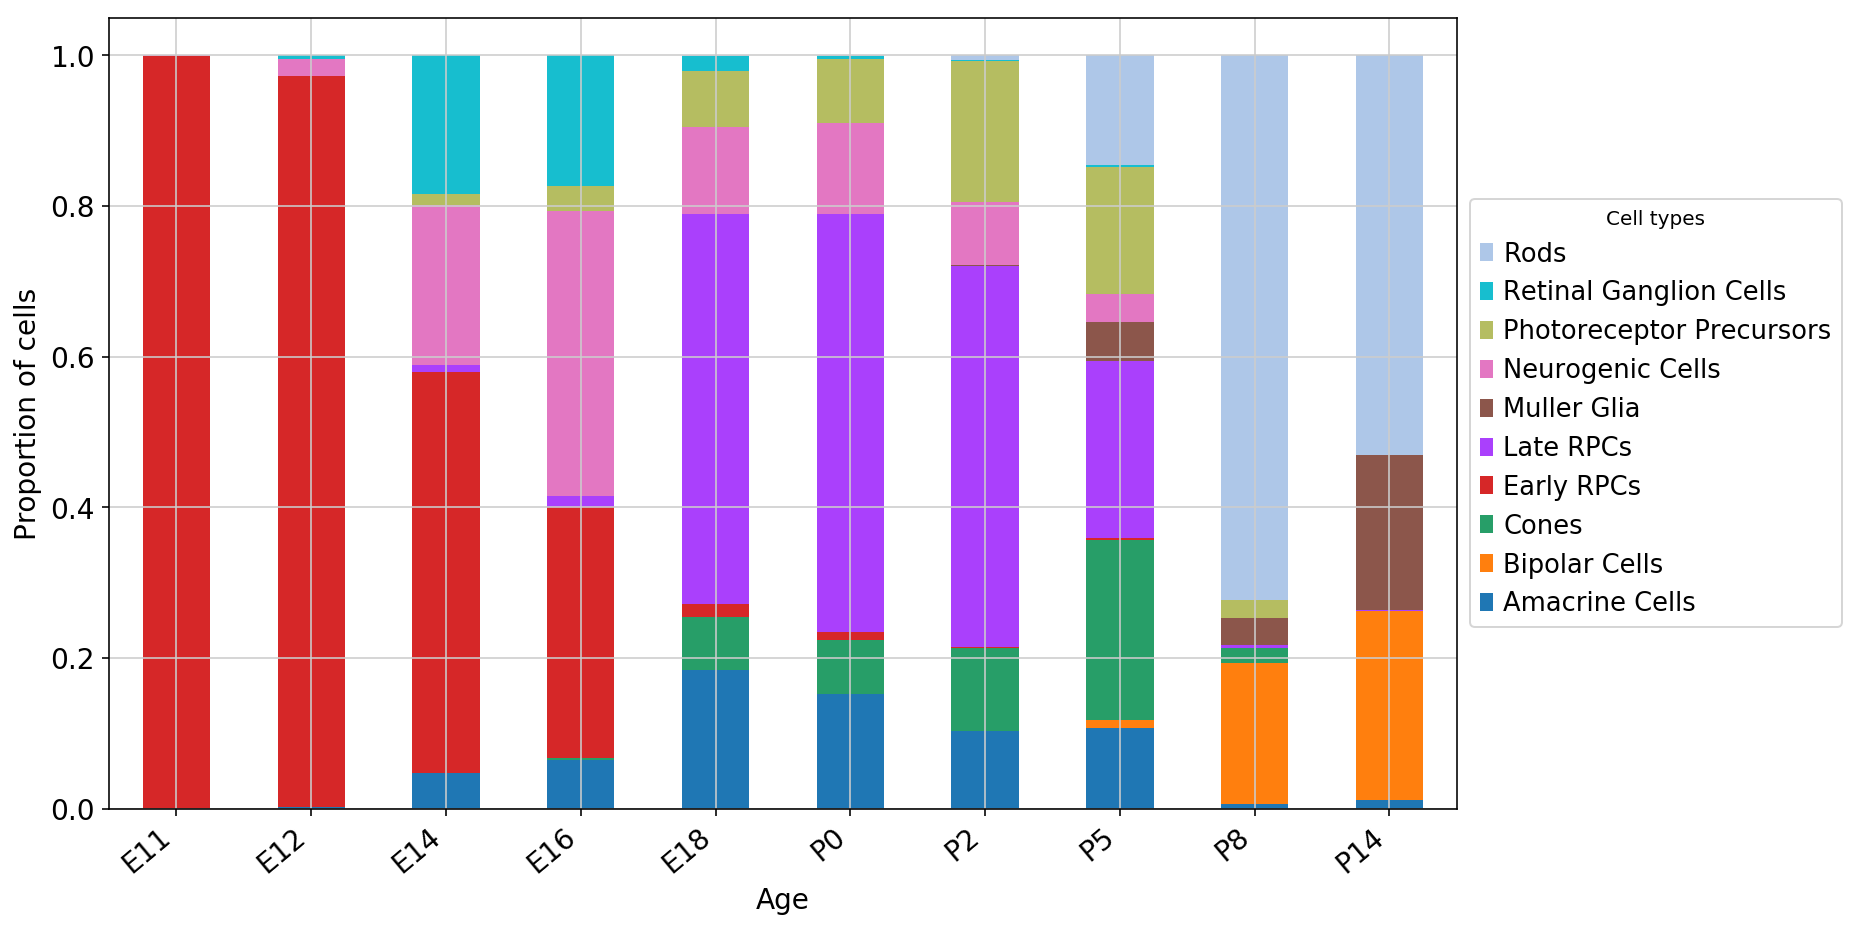

In [82]:
# Normalize columns so the values will be proportions
types_per_age = types_per_age.div(types_per_age.sum(axis=1), axis=0)

# Plotting stacked barplot
f, ax = plt.subplots(figsize=(15, 7))
types_per_age.plot.bar(ax=ax, stacked=True)

# Shrinking current axis by 20% and putting legend our of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell types', loc='center left', bbox_to_anchor=(1, 0.5))

# Setting angled xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')

# Setting axis labels
ax.set_ylabel('Proportion of cells')
ax.set_xlabel('Age')

plt.savefig('./images/bar_types_ages.pdf')

The above barplot clearly represents changes in the cell profiles as neural cells develop from early retinal progenitor cells (RPCs) to rods, muller glia and bipolar cells.

### Dimensionality reduction

The next few steps are aimed at the reproduction of the Fig 1. of the original paper, mainly the UMAP representation of the datat. First, we should reduce the dimensionality of the dataset for the following clustering of cells and UMAP.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:45)


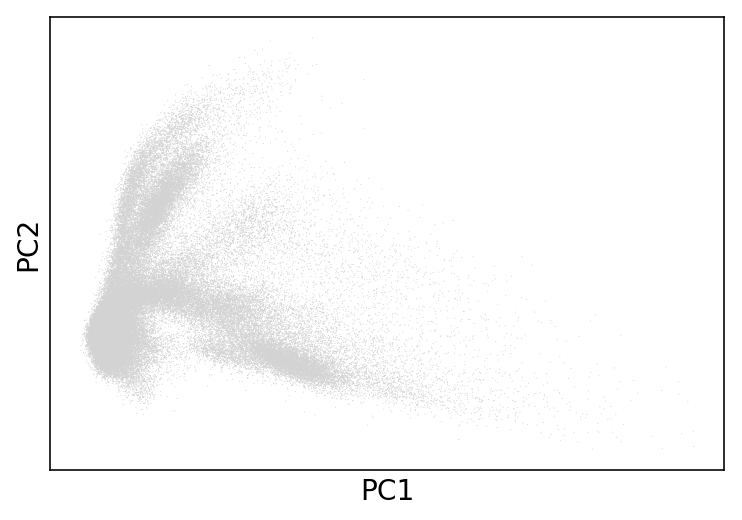

In [20]:
# Computing the PCA of the dataset and plotting it on the PCA axis
sc.tl.pca(adata)
sc.pl.pca(adata)

As expected, principal components struggles to distinguish biologically relevant groups inside the dataset, as we do not observe the formation of cell clusters.

Anyway they are useful for downstream analysis as they contain the most variance along them. Next step would be to decide how many principal components should we choose.

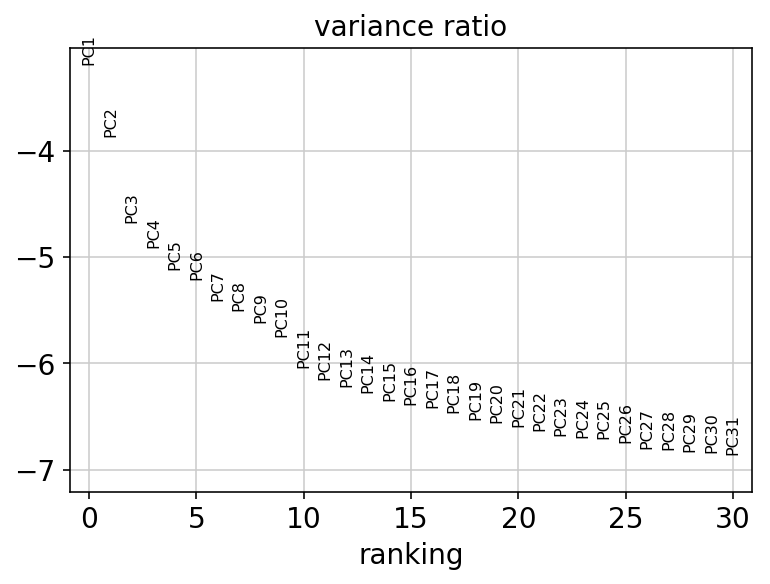

In [21]:
# Calculate the amount of variance principal components contain
sc.pl.pca_variance_ratio(adata, log=True)

Personally, first 25 principal components are sufficient for further analysis. Now let's compute neighborhood graph using extracted principal components and do the UMAP visualization.

computing neighbors
    using 'X_pca' with n_pcs = 25
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:57)


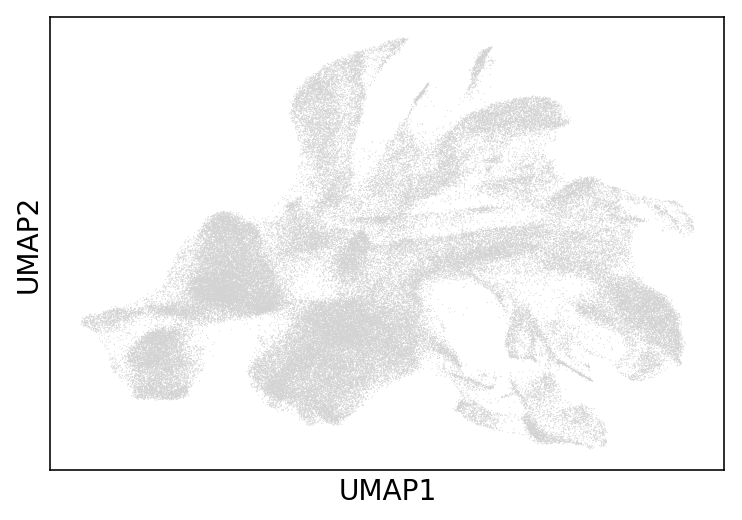

In [22]:
# Setting the number of used first principal components
n_pcs = 25

# Calculating the neighbourhood embedding graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=25)

# Calculating and plotting the UMAP plot
sc.tl.umap(adata)
sc.pl.umap(adata)

UMAP visualization reveals some groups in the dataset which may represent certain cell types. As we have the cell annotation of the whole dataset it is not necessary to do unsupervised clustering, but as we stick to a standard scRNA-seq pipeline, we would do this step anyway. We will use [Leiden](https://arxiv.org/abs/1810.08473) graph-clustering method (community detection based on optimizing modularity). 

running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:06:48)


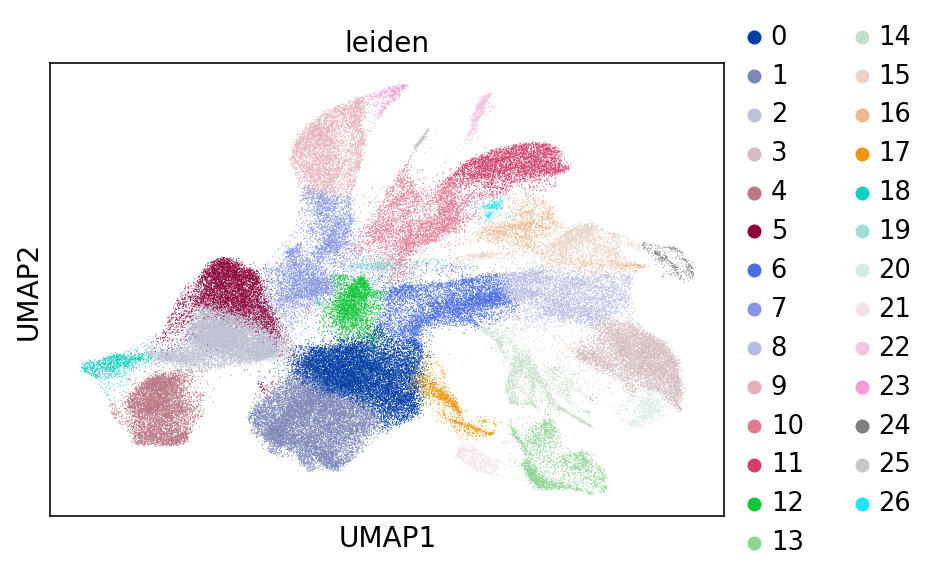

In [23]:
# Computing the Leiden clustering and coloring them on UMAP plot
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

Now we are ready to color the UMAP plot by cell's developmental age and type.

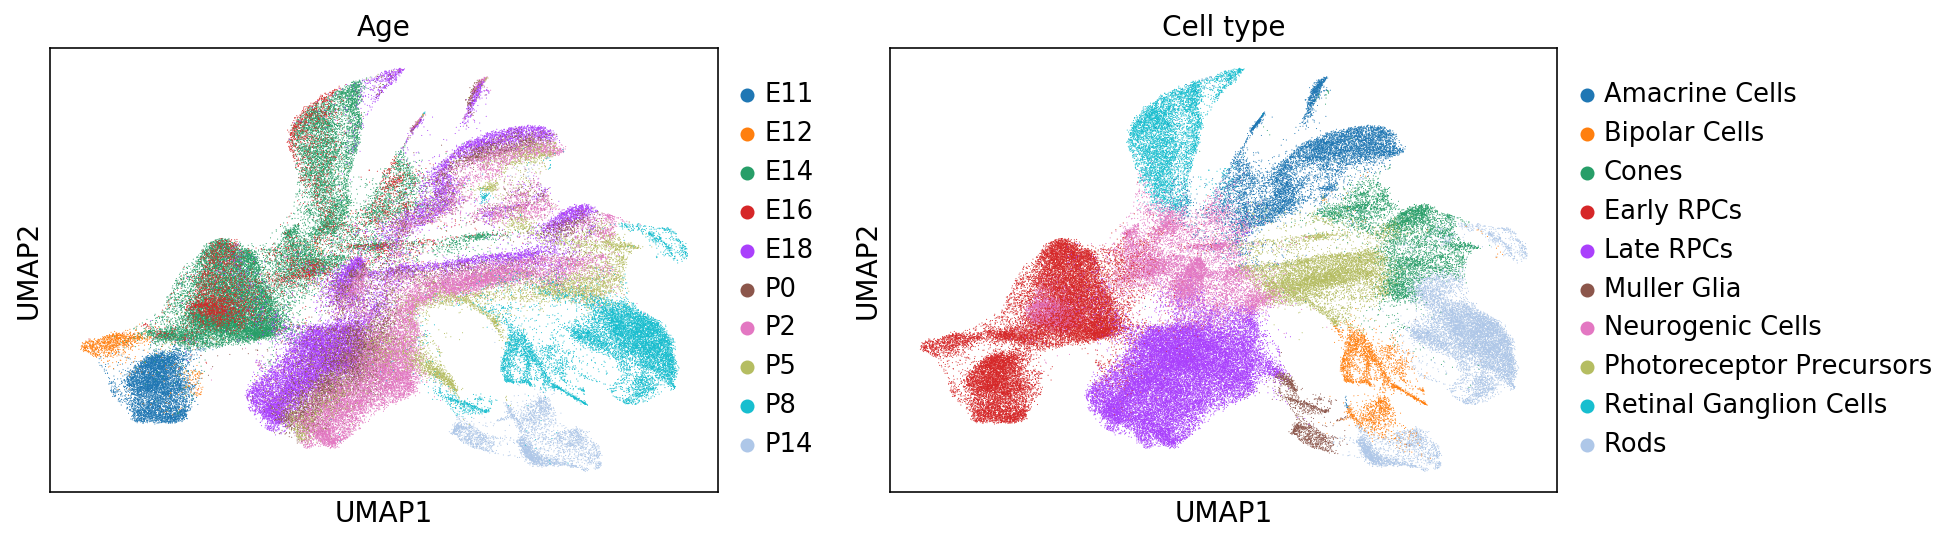

In [24]:
# Plotting umap with age and cell type coloring
sc.pl.umap(adata, color=['age', 'new_CellType'], save='_by_cell_type_by_age.pdf', title=['Age', 'Cell type'])

We could conclude that UMAP graph displays clear segmentation of data into distinct groups according to their cell type and developmental age. 

The next step is to do the differential expression analysis (DE) which is aimed at identification of genes that are differentially expressed between groups. These genes are potentially cell markers that define the cell types of individual cells. We will use simple, but still very popular Wilcoxon rank‐sum test. The grouping is based on cell types.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:32)


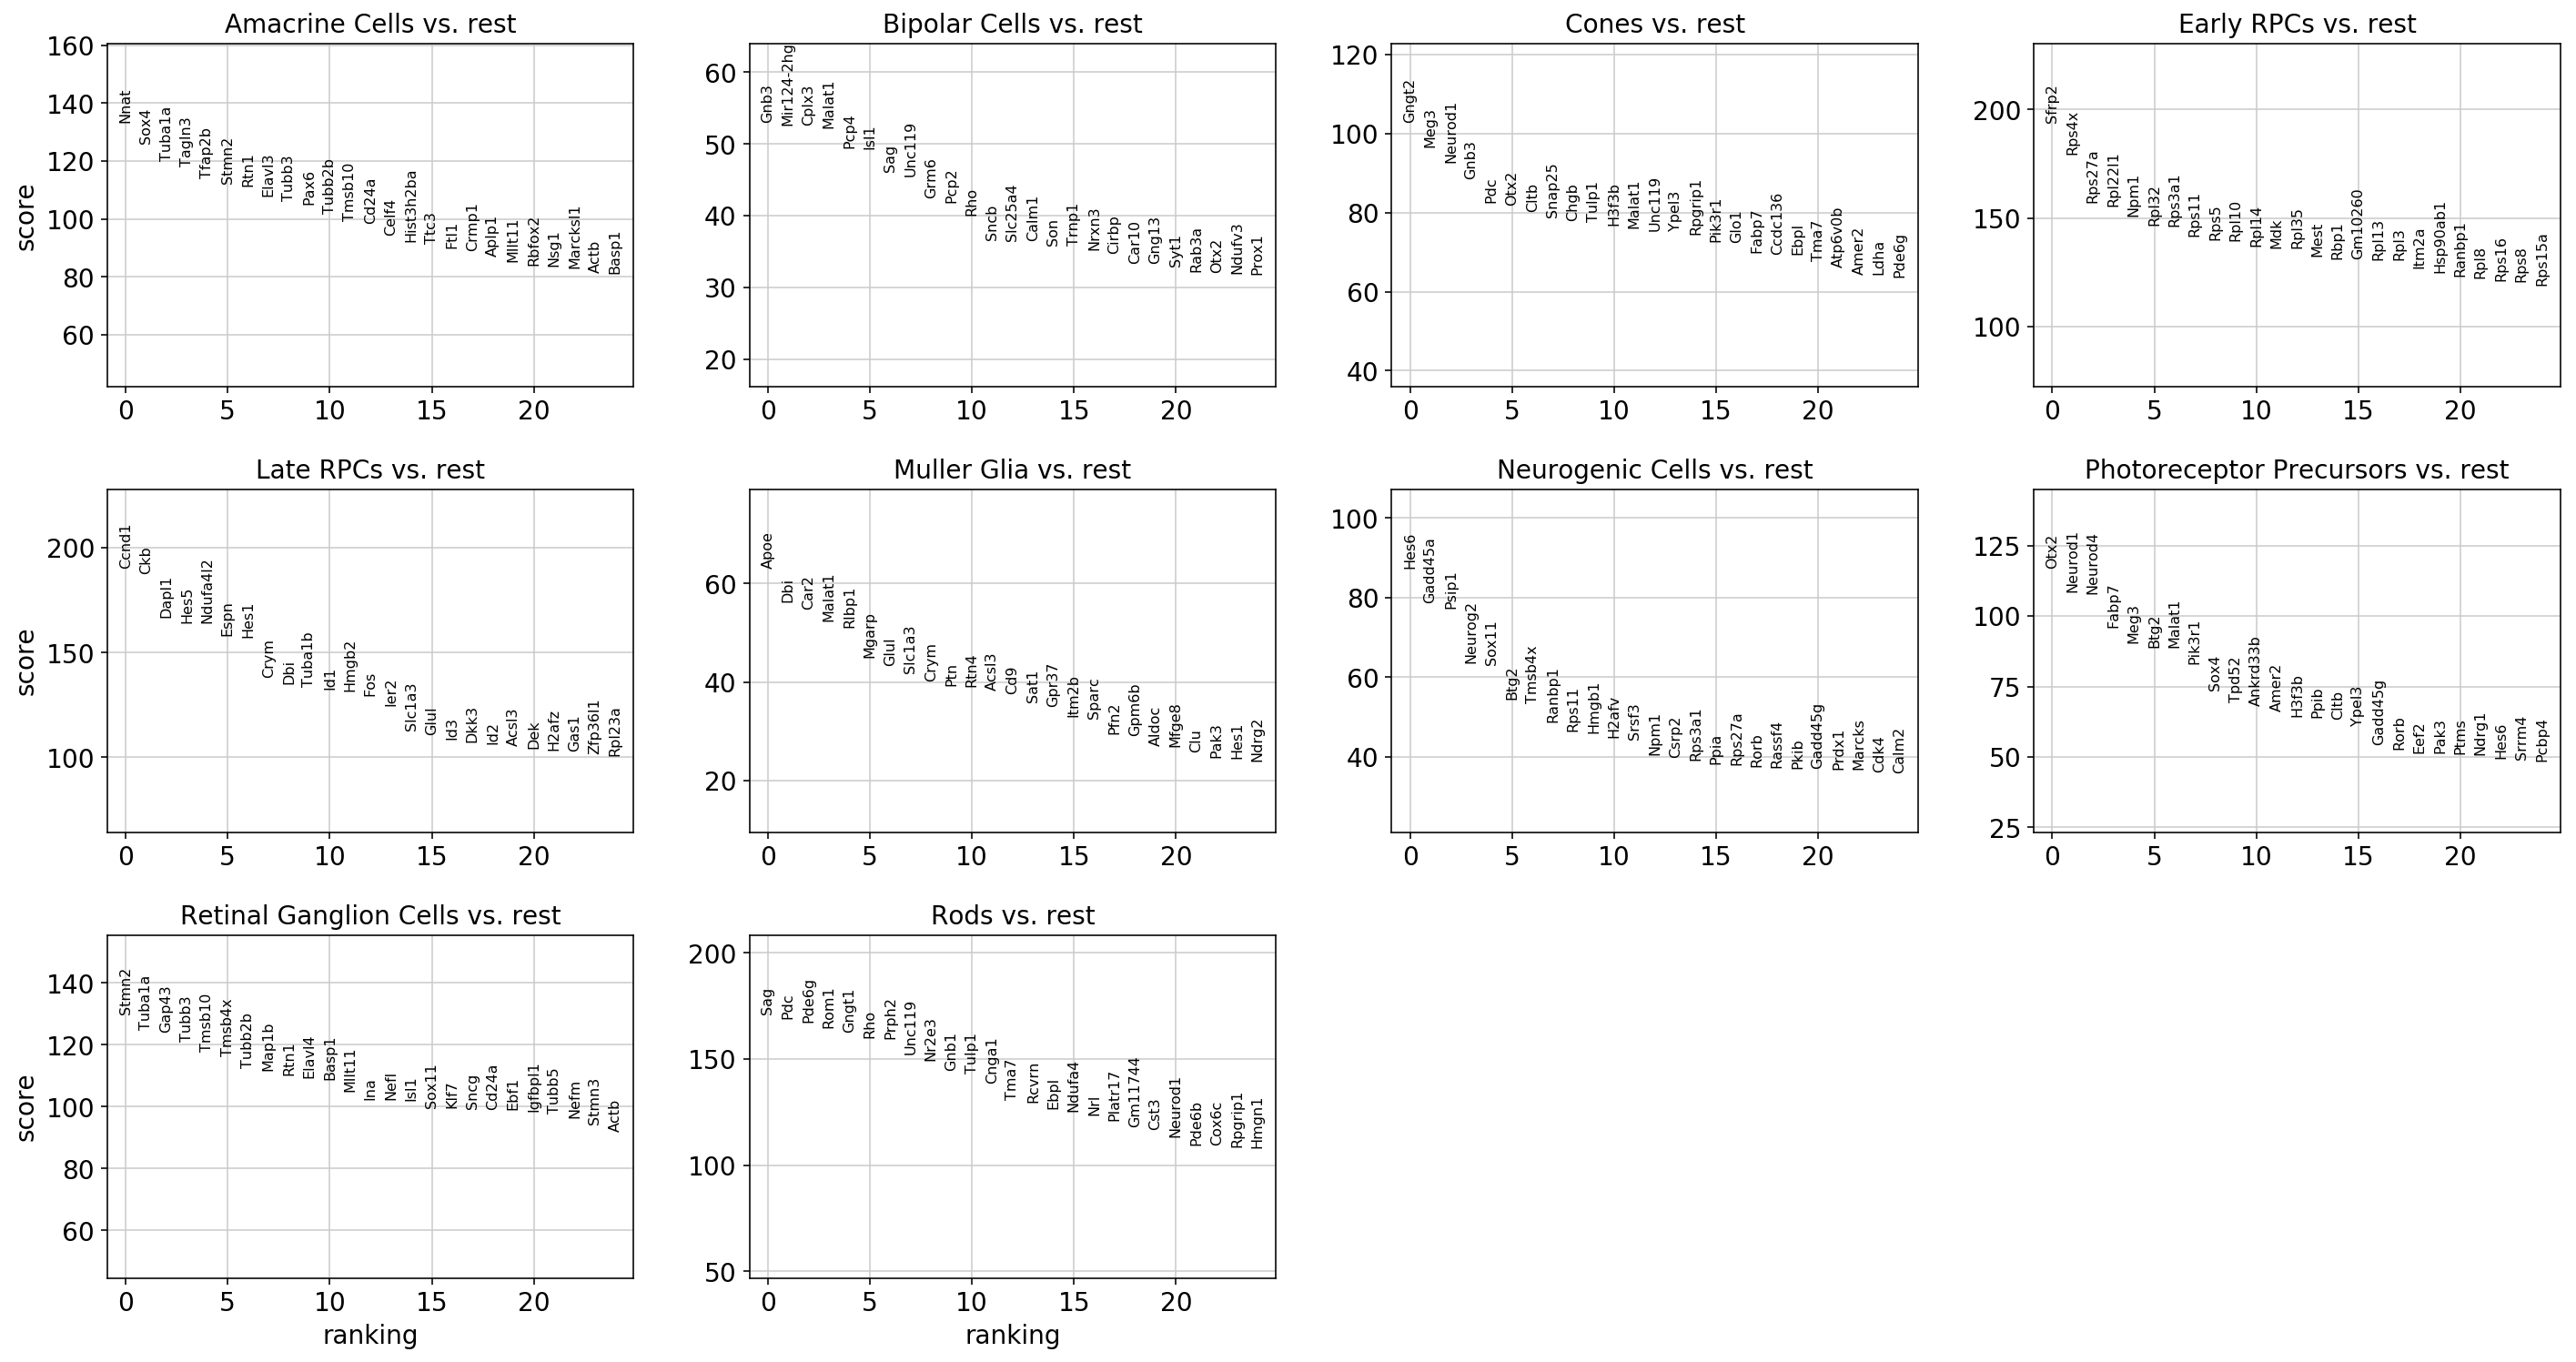

In [25]:
# Calculating the differentially expressed genes using t-test and ranking them
sc.tl.rank_genes_groups(adata, 'new_CellType', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

The plot above indicates the top differentially expressed genes ranked by Wilcoxon test. We may observe that the list includes genes that regulate retinal neural development (Atoh7, Neurog2, Ascl1), cell-cycle progression markers (Ccnd1, Cdk4), immune markers (C1qa, C1qb) and etc.

We will know reproduce the matrixplot from Fig 1 of the original paper. To do that we selected key neural development markers and focused only on a subset of neural cells.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Cell type']`


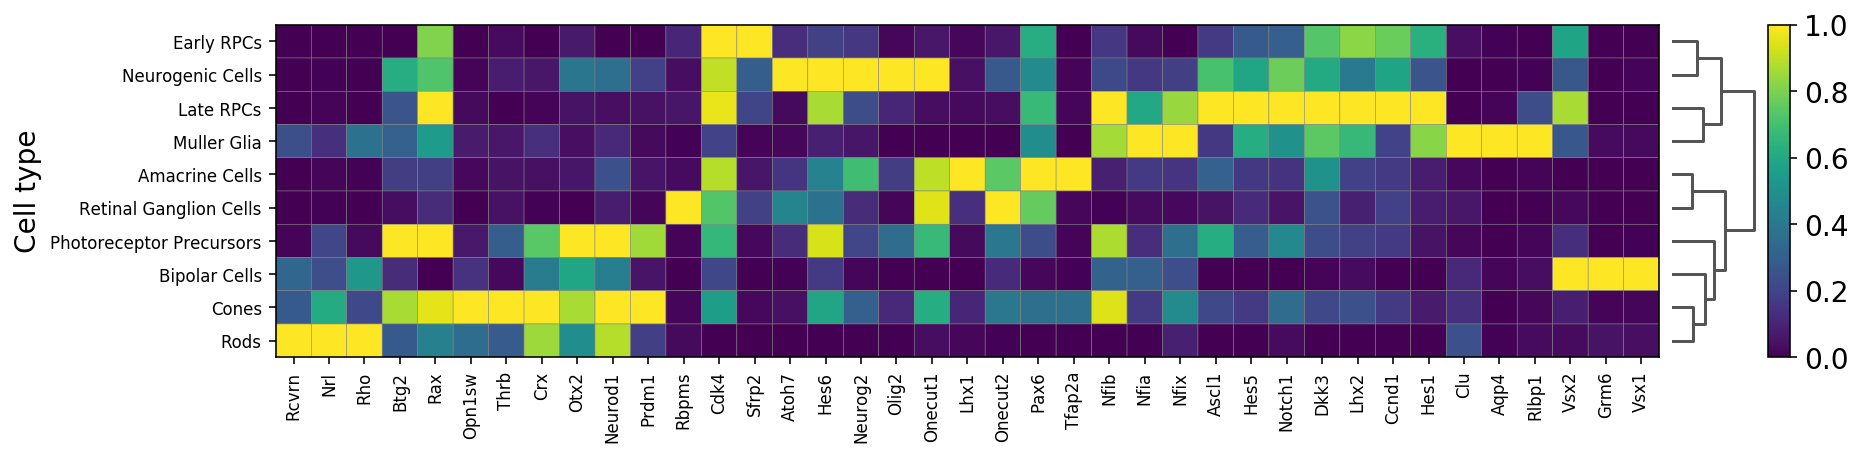

In [26]:
# Define neural development markers
marker_genes_dict = ['Rcvrn', 'Nrl', 'Rho', 'Btg2', 'Rax', 'Opn1sw', 'Thrb', 'Crx', 
                     'Otx2', 'Neurod1', 'Prdm1', 'Rbpms', 'Cdk4', 
                     'Sfrp2', 'Atoh7', 'Hes6', 'Neurog2', 'Olig2', 'Onecut1', 'Lhx1', 
                     'Onecut2', 'Pax6', 'Tfap2a', 'Nfib', 'Nfia', 'Nfix', 'Ascl1', 'Hes5', 
                     'Notch1', 'Dkk3', 'Lhx2', 'Ccnd1', 'Hes1', 'Clu', 'Aqp4', 'Rlbp1', 'Vsx2', 
                     'Grm6', 'Vsx1']

# Rename column for following visualization
adata.obs.rename(columns={'new_CellType' : 'Cell type'}, inplace=True)

# Plot the matrix
sc.pl.matrixplot(adata, marker_genes_dict, groupby='Cell type', 
                 dendrogram=True, standard_scale='var', var_group_rotation=30, save='_DE_genes.pdf');

We could conclude that the selected genes are, indeed, differentially expressed and hence define the phenotype of cell type.

### Data analysis 2

#### Analysis of cell cycle

Now we will focus on the cell cycle scoring. Firstly,  let us load the file that contains the list of cell cycle genes which was defined in [Tirosh et al, 2015](https://doi.org/10.1126/science.aad0501). One can find this file [here](https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1), although the represented genes are human orthologues. We changed the gene names manually.

In [27]:
# Loading cell cycle genes
cell_cycle_genes = [line.strip() for line in open('./data/regev_lab_cell_cycle_genes.txt')]

# Defining G2/M phase genes and S phase genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

Now we are ready to calculate the cell cycle score by finding differences in gene expressions of our `s_genes` and `g2m_genes` in relative to randomly sampled reference genes. After that we will make UMAP visualization with cell cycle phase coloring and cell types.

In [28]:
# Calculating cell cycle phase scoring
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    43 total control genes are used. (0:00:03)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    40 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


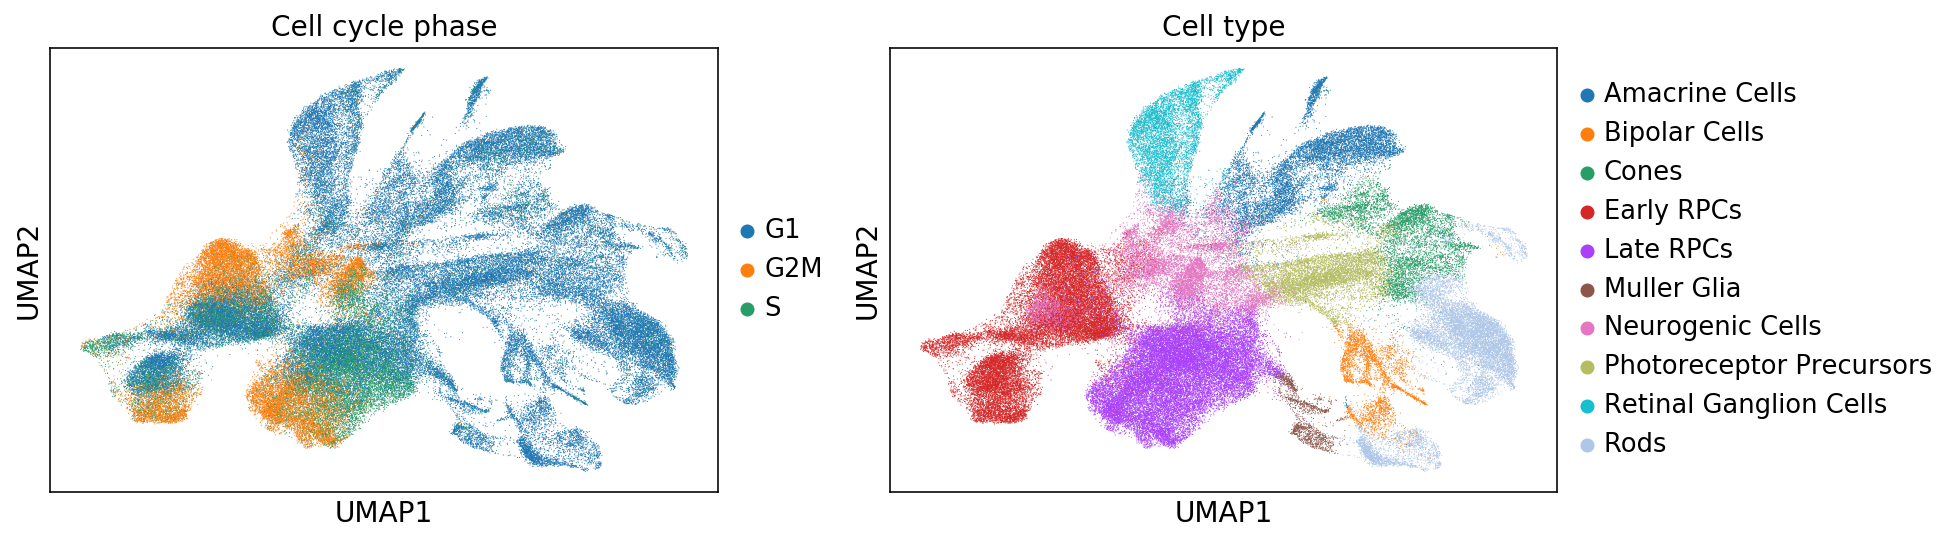

In [29]:
# Plotting UMAP with phase and cell type coloring
sc.pl.umap(adata, color=['phase', 'Cell type'], title=['Cell cycle phase', 'Cell type'])

Let us make a more quantitative visualization of proportions of cells based on their cell cycle phase. To achieve that we will make stacked plot with similar structure as in previous section.

In [84]:
# Getting cell cycle phase frequencies for each developmental age
phase_per_age = (adata.obs  # Getting the cell annotation dataframe
                     # Grouping dataframe by age and cell cycle phase
                     .groupby(['age', 'phase'])
                     # Count number of cells in each group
                     .count()
                     # Pivot the table such Age is index, and CellType are columns
                     .unstack('phase')['barcode']
                     # Fill NaN values with zeros
                     .fillna(0)
                )
phase_per_age

phase     G1   G2M     S
age                     
E11     2631  2334  1716
E12      341   163   794
E14    14989  7555  3948
E16     2968  1325   998
E18    12781  4766  4219
P0      4407  1316  3622
P2      9378  1795  5491
P5      5432   438   351
P8     10660     3   822
P14     3439     4    93

Let us now plot the stacked barplot and visualize the frequency of certain cell type in each age group.

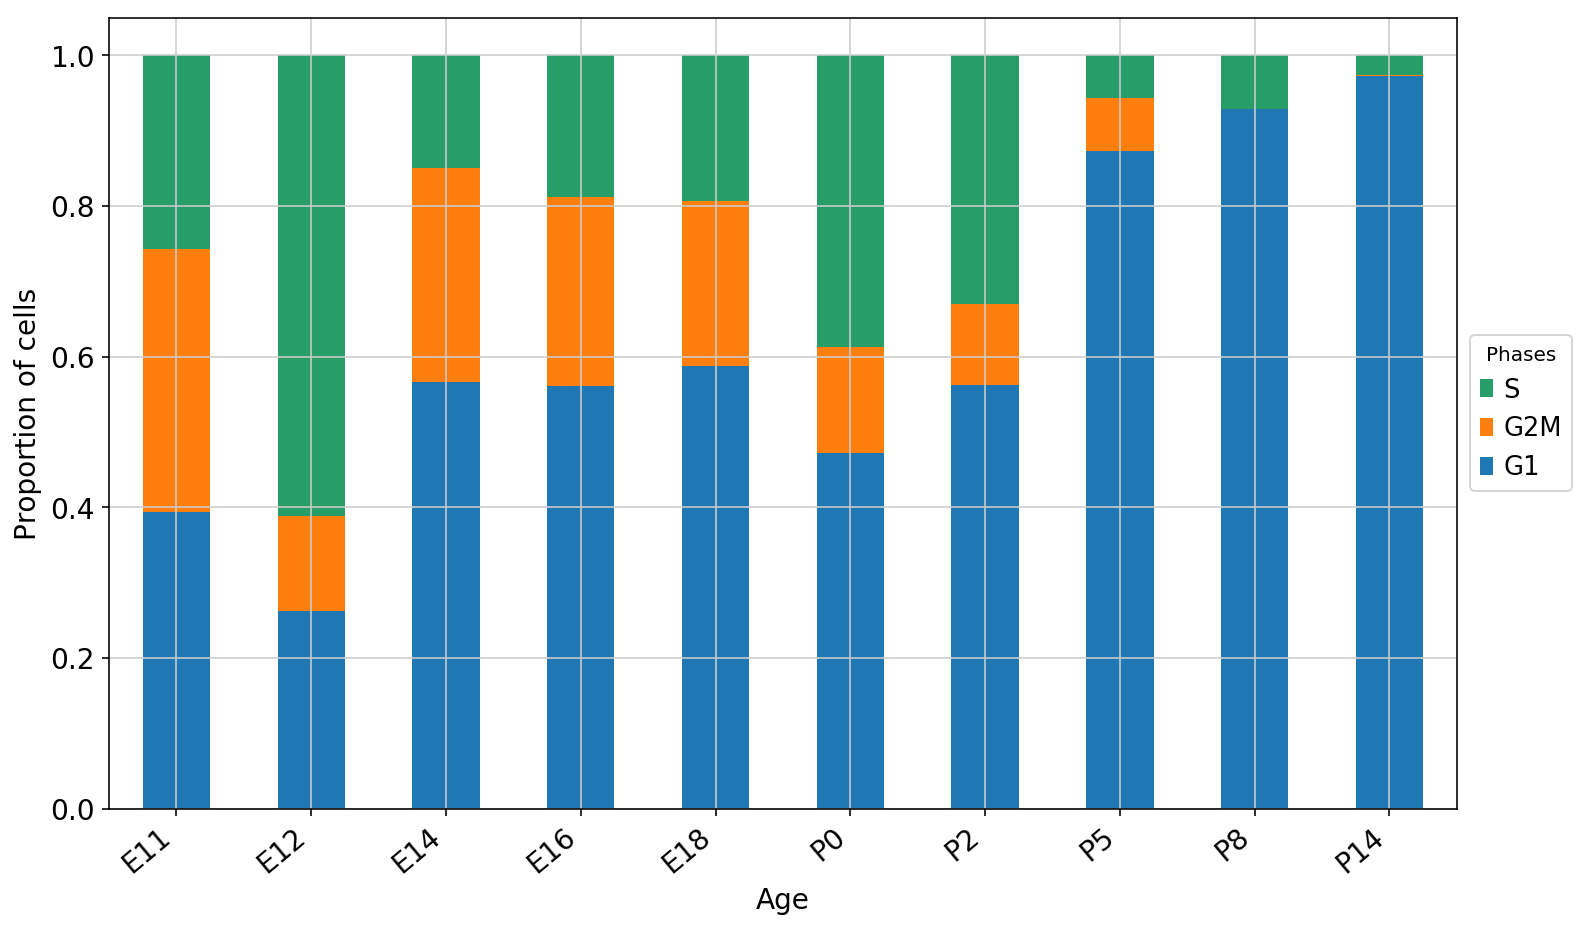

In [85]:
# Normalize columns so the values will be proportions
phase_per_age = phase_per_age.div(phase_per_age.sum(axis=1), axis=0)

# Plotting stacked barplot
f, ax = plt.subplots(figsize=(15, 7))
phase_per_age.plot.bar(ax=ax, stacked=True)

# Shrinking current axis by 20% and putting legend our of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Phases', loc='center left', bbox_to_anchor=(1, 0.5))

# Setting angled xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')

# Setting axis labels
ax.set_ylabel('Proportion of cells')
ax.set_xlabel('Age')

plt.savefig('./images/bar_phases_ages.pdf')

We observe a clear transition from highly proliferative cells to the terminal mature cells. Let us now look at the cell types.

In [86]:
# Getting cell types frequencies for cell cycle phase
types_per_phase = (adata.obs  # Getting the cell annotation dataframe
                     # Grouping dataframe by cell cycle phase and cell type
                     .groupby(['phase', 'Cell type'])
                     # Count number of cells in each group
                     .count()
                     # Pivot the table such Age is index, and CellType are columns
                     .unstack('Cell type')['barcode']
                     # Fill NaN values with zeros
                     .fillna(0)
                )
types_per_phase

Cell type  Amacrine Cells  Bipolar Cells   Cones  Early RPCs  Late RPCs  \
phase                                                                     
G1                 8621.0         2914.0  5183.0      9467.0     9749.0   
G2M                  63.0            0.0    21.0      9117.0     6541.0   
S                   847.0          195.0   584.0      5682.0    10430.0   

Cell type  Muller Glia  Neurogenic Cells  Photoreceptor Precursors  \
phase                                                                
G1              1330.0            6438.0                    6917.0   
G2M                1.0            3763.0                      44.0   
S                135.0            2745.0                     463.0   

Cell type  Retinal Ganglion Cells     Rods  
phase                                       
G1                         5804.0  10603.0  
G2M                         143.0      6.0  
S                           368.0    605.0

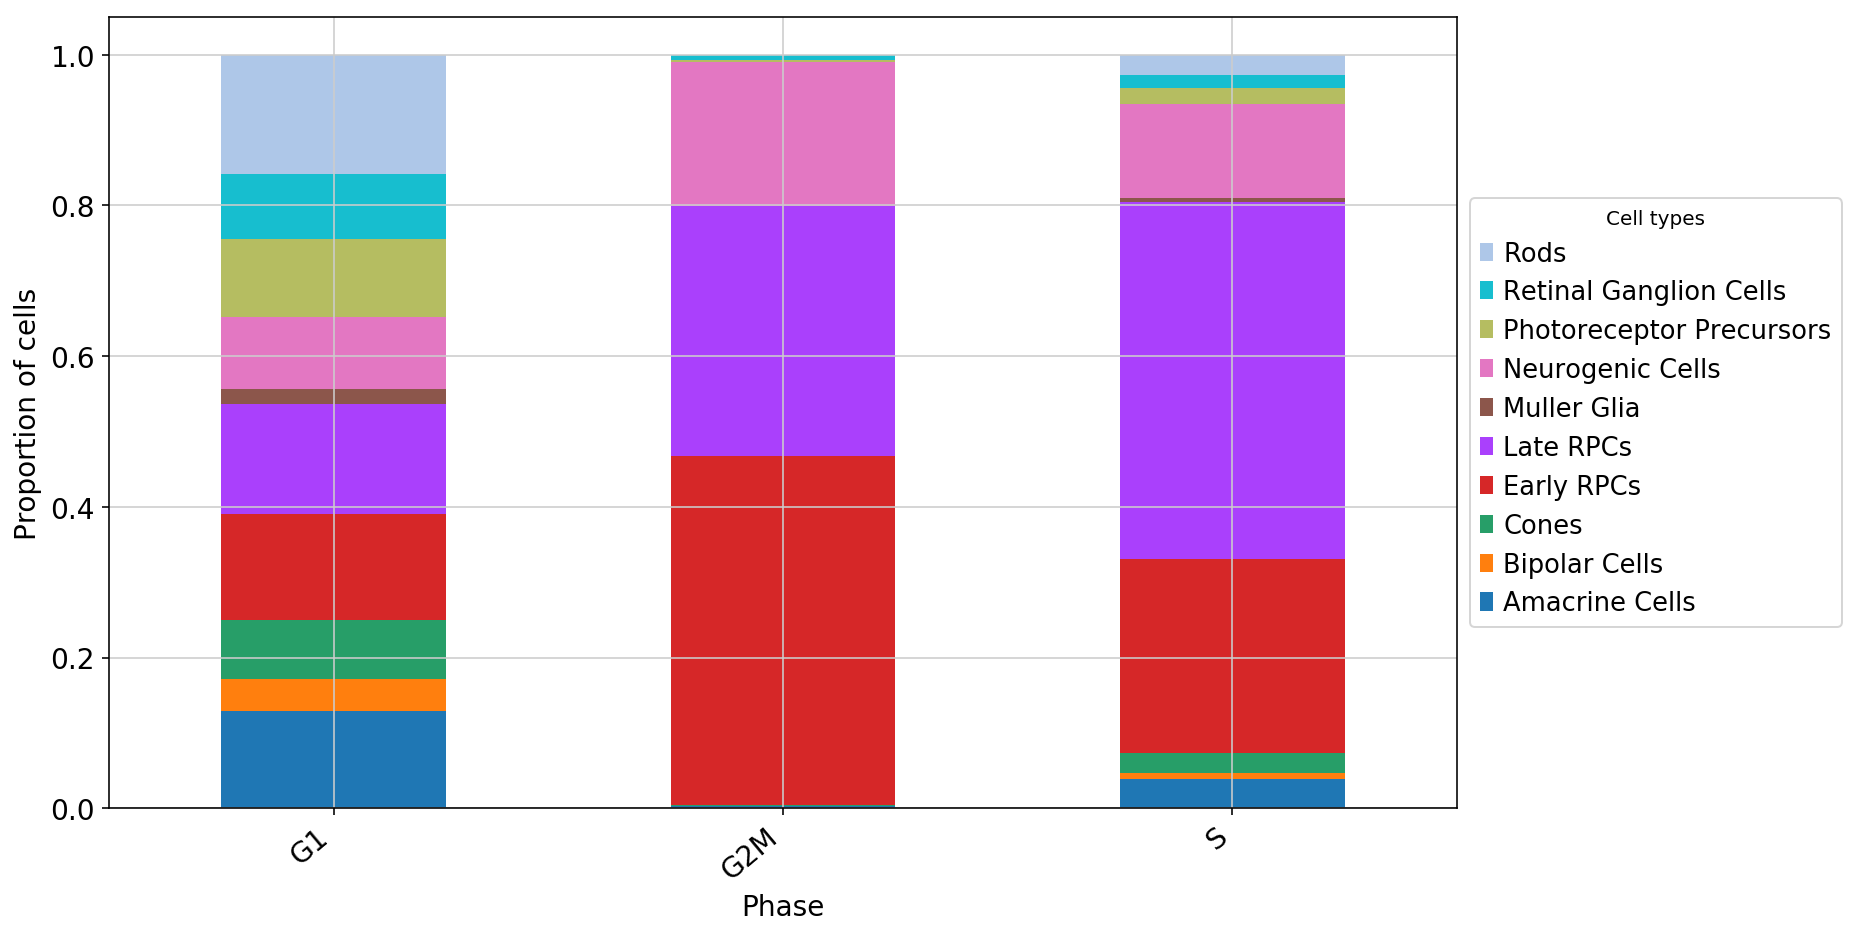

In [87]:
# Normalize columns so the values will be proportions
types_per_phase = types_per_phase.div(types_per_phase.sum(axis=1), axis=0)

# Plotting stacked barplot
f, ax = plt.subplots(figsize=(15, 7))
types_per_phase.plot.bar(ax=ax, stacked=True)

# Shrinking current axis by 20% and putting legend our of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell types', loc='center left', bbox_to_anchor=(1, 0.5))

# Setting angled xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')

# Setting axis labels
ax.set_ylabel('Proportion of cells')
ax.set_xlabel('Phase')

plt.savefig('./images/bar_phases_types.pdf')

As expected, RPCs and neurogenic cells have active cell cycle (G2/M and S phases), while fully-differentiated cells such as rods and cons are not dividing.

#### Trajectory inference based on PAGA

Now it will be interesting to map our dataset to the PAGA graph which is a coarse abstraction of connectivity structures in the single-cell data. PAGA graph is used for following pseudotime trajectory inference which we will focus on in this section. The graph layouts would be computed either using UMAP or [ForceAtlas2](https://doi.org/10.1371/journal.pone.0098679).

In [35]:
%%time  # This cell takes a loooong time

# Run the PAGA
sc.tl.paga(adata, groups='Cell type')

# Compute the force-directed graph
sc.tl.draw_graph(adata, init_pos='paga')

# Compute the UMAP-based graph
sc.tl.umap(adata, init_pos='paga')

# Set the root for the diffusion pseudotime
adata.uns['iroot'] = np.flatnonzero(adata.obs['Cell type']  == 'Early RPCs')[0]

# Run diffusion pseudotime
sc.tl.dpt(adata)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:05)


--> added 'pos', the PAGA positions (adata.uns['paga'])


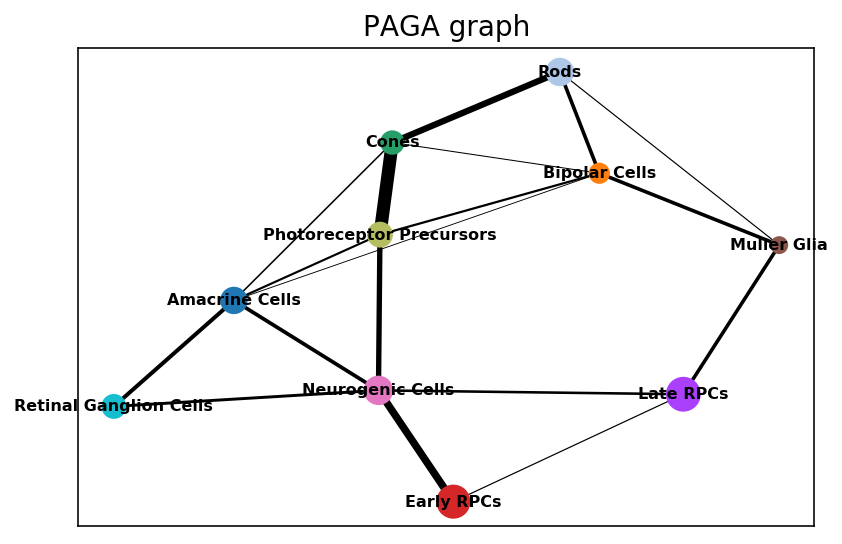

In [71]:
# Visualize the PAGA graph
sc.pl.paga(adata, color='Cell type', fontsize=8, save='_graph.pdf', title='PAGA graph')

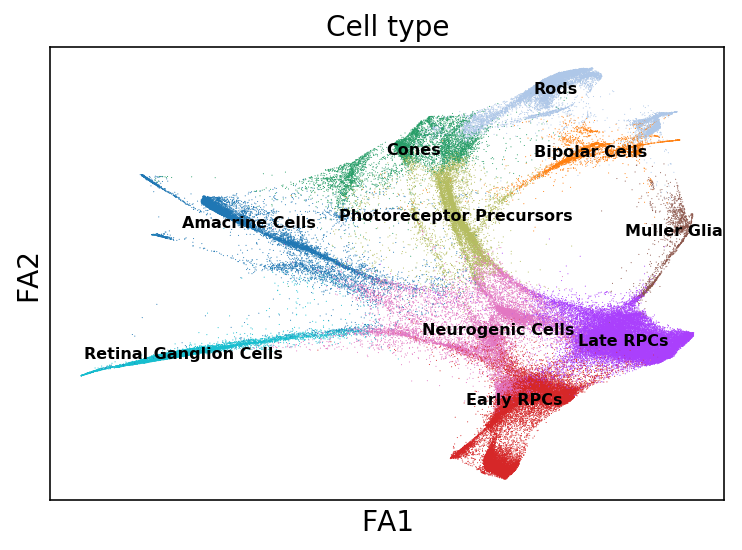

In [78]:
# Visualize the cell type transformations on force-directed graph
sc.pl.draw_graph(adata, color='Cell type', legend_fontsize=8, legend_loc='on data', save='_celltype.pdf')

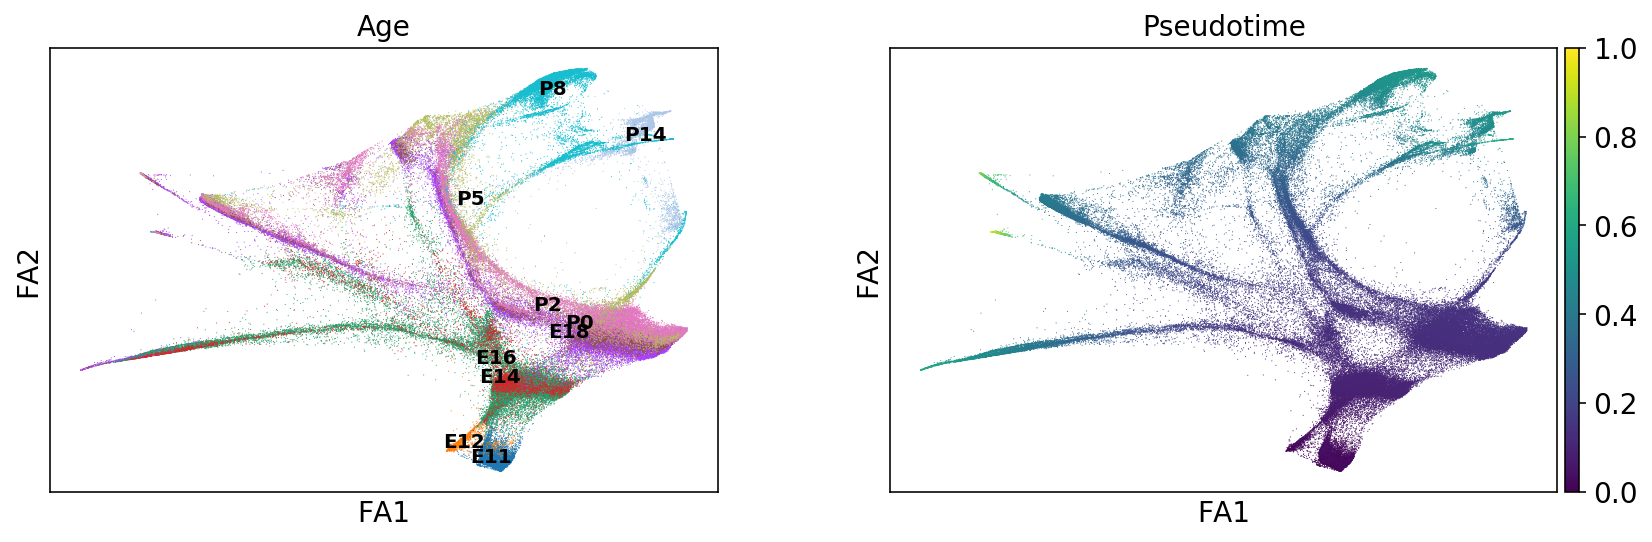

In [77]:
# Visualize age and pseudotime on force-directed graphs
sc.pl.draw_graph(adata, color=['age', 'dpt_pseudotime'], legend_loc='on data', title=['Age', 'Pseudotime'], save='_age_pseudotime.pdf')

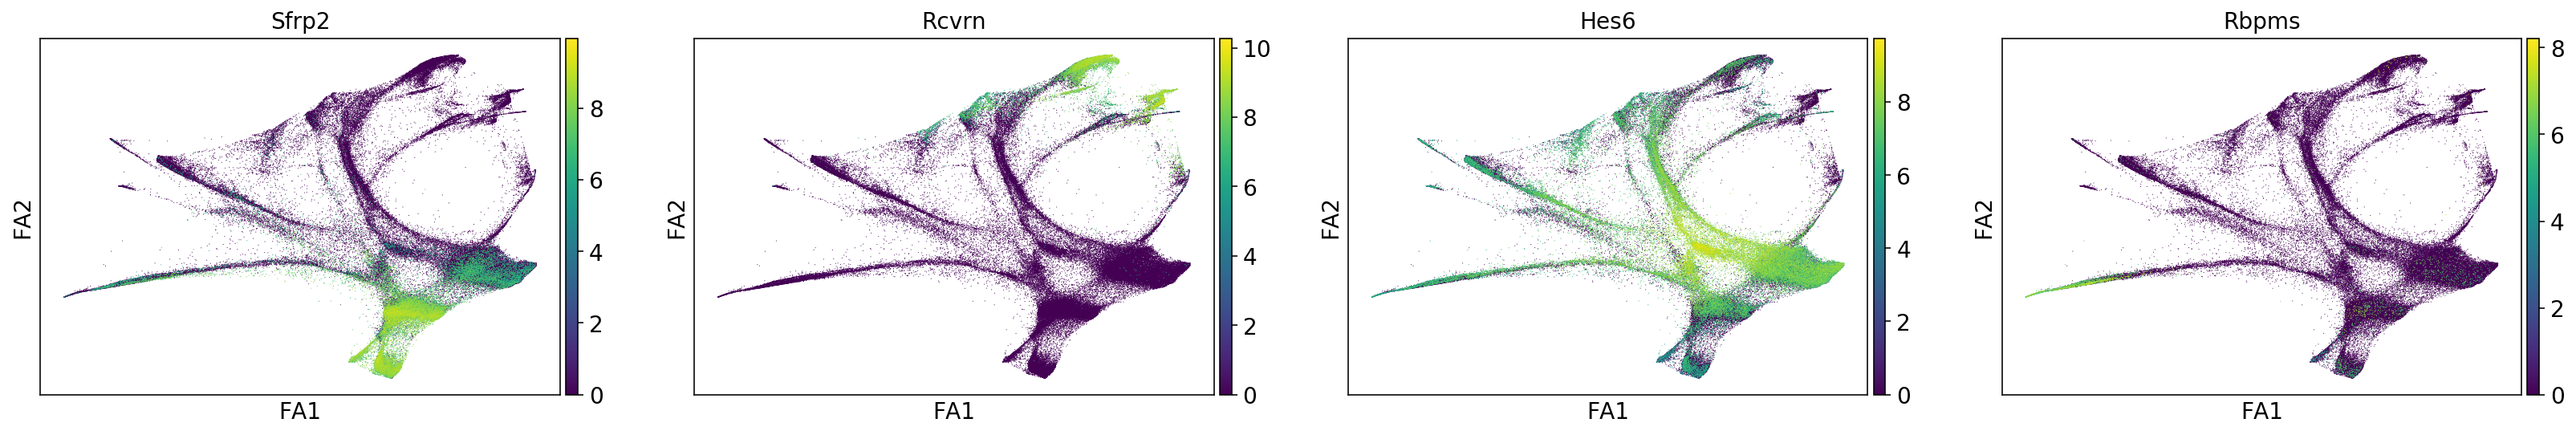

In [76]:
# Markers to highlight
new_markers = ['Sfrp2', 'Rcvrn', 'Hes6', 'Rbpms']

# Visualize markers expression on a force-directed graph
sc.pl.draw_graph(adata, color=new_markers, legend_loc='on data', save='_marker_genes.pdf')

PAGA displays cell transformations from early progenitors cell to terminal mature cells, as well as corresponding change in marker genes expression. Moreover, it gives you a more detailed description of the developing process by showing the connectivity trajectories.